<a href="https://colab.research.google.com/github/vaibhavraok/GNCIPL/blob/main/Disease_Diagnosis_Accuracy_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ucimlrepo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Fetch dataset
heart_disease = fetch_ucirepo(id=45)

# Features & targets
X = heart_disease.data.features
y = heart_disease.data.targets

# Let's inspect the target column name
print("Target columns:", y.columns)

# Merge features + target
df = pd.concat([X, y], axis=1)

# Clean
df = df.drop_duplicates()
df = df.dropna()

# Rename target column to "target" (for consistency)
df = df.rename(columns={y.columns[0]: "target"})

print("Shape after cleaning:", df.shape)
print("\nTarget Distribution:\n", df['target'].value_counts())
df.head()


Target columns: Index(['num'], dtype='object')
Shape after cleaning: (297, 14)

Target Distribution:
 target
0    160
1     54
2     35
3     35
4     13
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


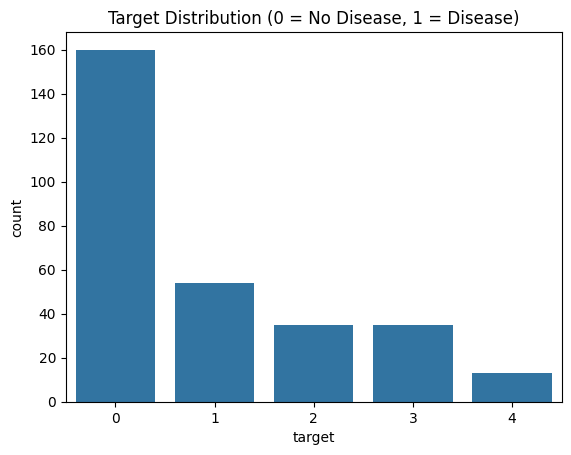

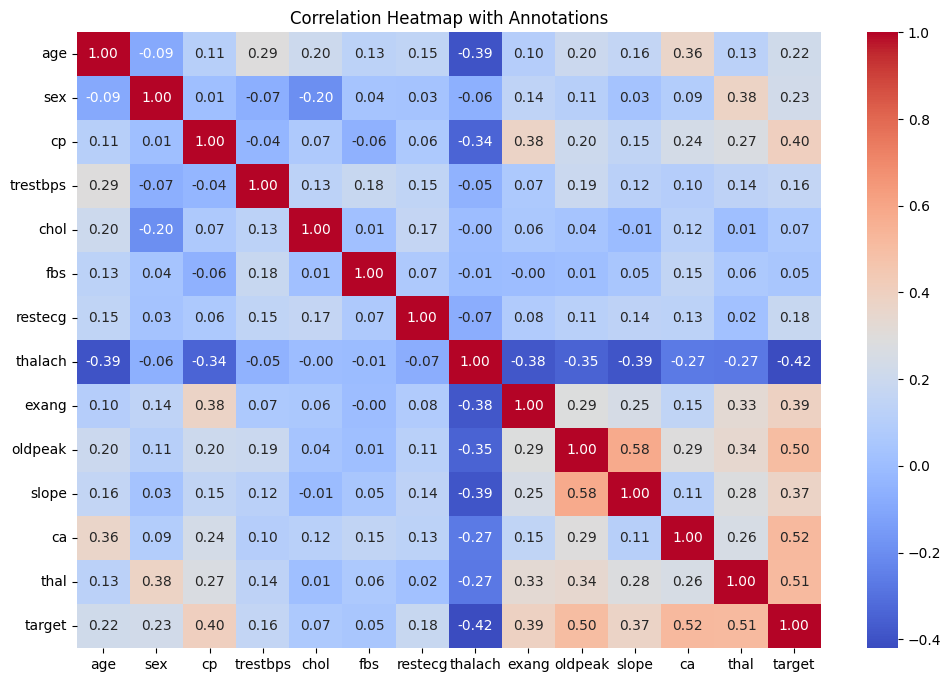

In [ ]:
sns.countplot(x='target', data=df)
plt.title("Target Distribution (0 = No Disease, 1 = Disease)")
plt.show()
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Heatmap with Annotations")
plt.show()



In [ ]:
# Cleaning
df = df.drop_duplicates()
df = df.dropna()

df['target'] = df[df.columns[-1]].apply(lambda x: 1 if x > 0 else 0)


X = df.drop("target", axis=1)
y = df["target"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


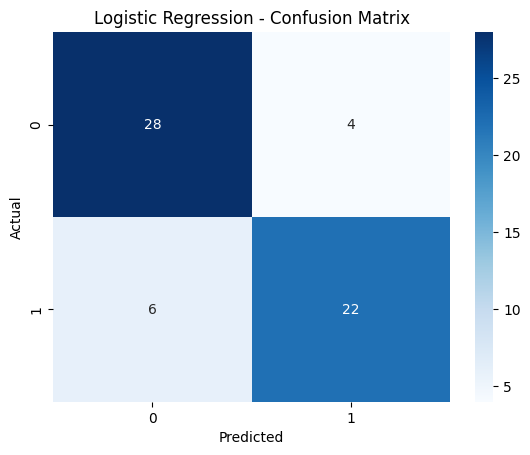


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.85      0.79      0.81        28

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60



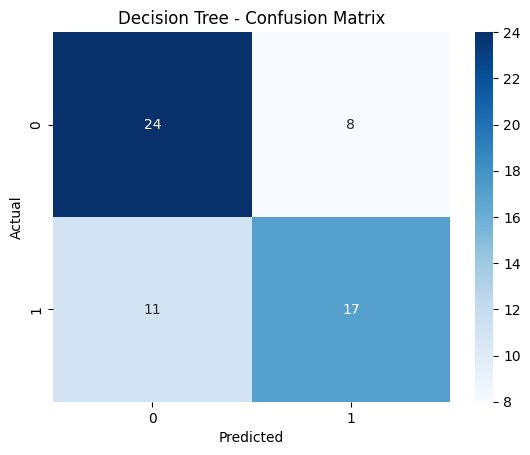


Decision Tree Report:
               precision    recall  f1-score   support

           0       0.69      0.75      0.72        32
           1       0.68      0.61      0.64        28

    accuracy                           0.68        60
   macro avg       0.68      0.68      0.68        60
weighted avg       0.68      0.68      0.68        60



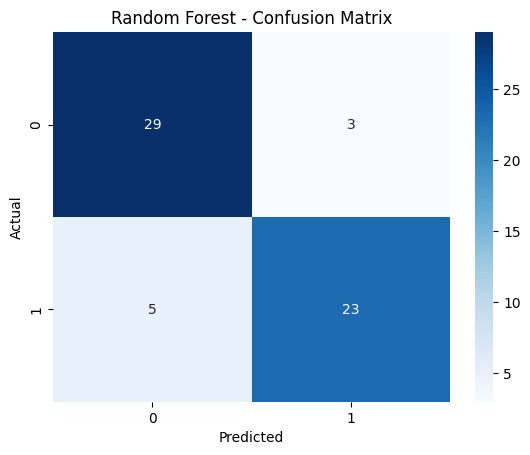


Random Forest Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.88      0.82      0.85        28

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.87        60
weighted avg       0.87      0.87      0.87        60



In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": auc
    }

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(f"\n{name} Report:\n", classification_report(y_test, y_pred, zero_division=0))



Model Comparison:
                      Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regression  0.833333   0.846154  0.785714  0.814815  0.949777
Decision Tree        0.683333   0.680000  0.607143  0.641509  0.678571
Random Forest        0.866667   0.884615  0.821429  0.851852  0.941406


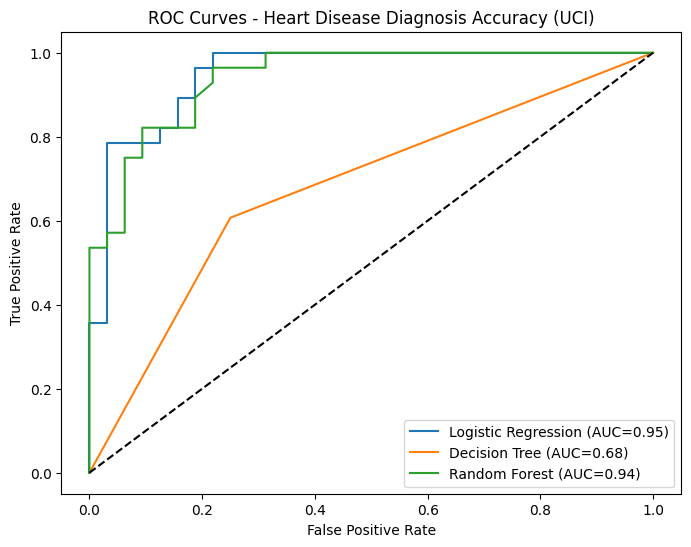

In [ ]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison:\n", results_df)

plt.figure(figsize=(8,6))
for name, model in models.items():
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Heart Disease Diagnosis Accuracy (UCI)")
plt.legend()
plt.show()
